In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

In [2]:
#To praktycznie zostaje tak jak poprzednio
(x_train, y_train), (x_test, y_test) = mnist.load_data()



In [3]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [4]:
x_test.shape

(10000, 28, 28, 1)

In [5]:
# parametry sieci
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
layer_filters = [32, 64]

In [6]:
#Koder
inputs = Input(shape=input_shape, name='koder_wejscie')
x = inputs
# stos warstw Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)
  

In [7]:
shape = K.int_shape(x)

In [8]:
shape

(None, 7, 7, 64)

In [9]:
x = Flatten()(x)
latent = Dense(latent_dim, name='wektor_niejawny')(x)

In [10]:
encoder = Model(inputs,latent,name='koder')
encoder.summary()

Model: "koder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 koder_wejscie (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 wektor_niejawny (Dense)     (None, 16)                50192     
                                                                 
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


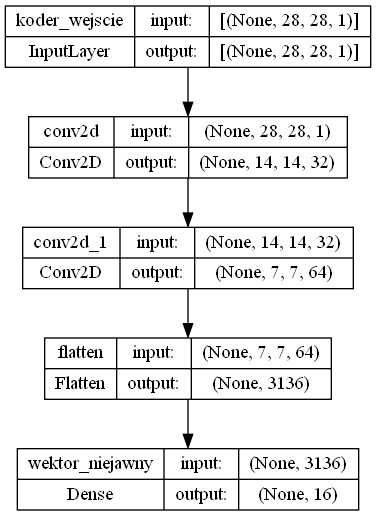

In [11]:
plot_model(encoder,
           to_file='koder.png',
           show_shapes=True)

In [12]:
# budowanie modelu dekodera
latent_inputs = Input(shape=(latent_dim,), name='dekoder_wejscie')
# używamy wcześniej zachowanego kształtu (7, 7, 64)
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# z wektora do kształtu odpowiedniego dla transponowanej conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [13]:
shape[1]

7

In [14]:
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

In [15]:
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='dekoder_wyjscie')(x)

In [16]:
decoder = Model(latent_inputs,outputs,name='dekoder')
decoder.summary()

Model: "dekoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dekoder_wejscie (InputLayer  [(None, 16)]             0         
 )                                                               
                                                                 
 dense (Dense)               (None, 3136)              53312     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                           

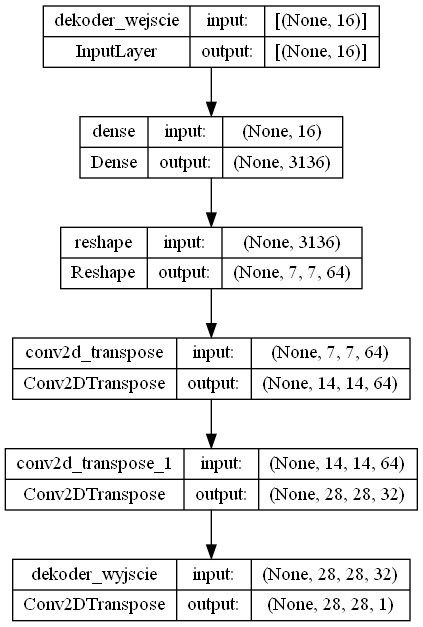

In [17]:
plot_model(decoder,to_file='dekoder.png',show_shapes=True)

Model: "autoenkoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 koder_wejscie (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 koder (Functional)          (None, 16)                69008     
                                                                 
 dekoder (Functional)        (None, 28, 28, 1)         108993    
                                                                 
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


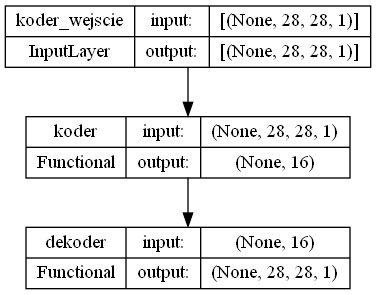

In [18]:
#Autoenkoder
autoencoder = Model(inputs,decoder(encoder(inputs)),name='autoenkoder')
autoencoder.summary()
plot_model(autoencoder,to_file='autoenkoder.png',show_shapes=True)

In [19]:
#Funkcja straty
autoencoder.compile(loss='mse',optimizer='adam')

In [20]:
#Trenowanie
autoencoder.fit(x_train,x_train,
               validation_data=(x_test,x_test),
               epochs = 1,
               batch_size=batch_size)

1875/1875 [==============================] - 41s 22ms/step - loss: 0.0211 - val_loss: 0.0108


In [21]:
# prognozowanie rezultatu działania sieci autokodującej na danych testowych
x_decoded = autoencoder.predict(x_test)

313/313 [==============================] - 3s 10ms/step


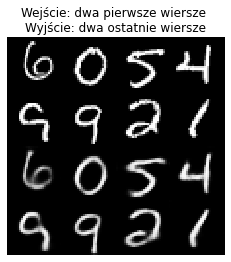

In [22]:
imgs = np.concatenate([x_test[100:108], x_decoded[100:108]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Wejście: dwa pierwsze wiersze \nWyjście: dwa ostatnie wiersze')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('we_wy.png')
plt.show()

In [23]:
import os
def plot_results(models,data,batch_size=32,model_name="Dwuwymiarowa siec autokodujaca"):
    encoder,decoder = models
    x_test,y_test = data
    xmin = ymin = -4
    xmax = ymax = +4
    os.makedirs(model_name,exist_ok=True)
    filename = os.path.join(model_name,"niejawny_2S.png")
    z = encoder.predict(x_test,batch_size=batch_size)
    plt.figure(figsize=(12,10))
    
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    
    z = z[0::2]
    y_test = y_test[0::2]
    plt.scatter(z[:,0],z[:,1],marker="")
    for i, digit in enumerate(y_test):
        axes.annotate(digit,(z[i,0],z[i,1]))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()
    
    filename = os.path.join(model_name,"CyfryNadNiejawna.png")
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size*n,digit_size*n))
    grid_x = np.linspace(xmin,xmax,n)
    grid_y = np.linspace(ymin, ymax, n)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = np.array([[xi, yi]])
            x_decoded = decoder.predict(z)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()    

In [27]:
def plot_results(models,
                 data,
                 batch_size=32,
                 model_name="autoencoder_2dim"):
    """	Wykreśla dwuwymiarowe wartości niejawne w postaci wykresu rozrzutu
		a następnie ryzuje cyfry MNIST w funkcji dwuwymiarowego 
		wektora niejawnego.
	
	Argumenty:
		models(list): modele kodera i dekodera
		data(list): dane testowe i etykiety
		batch_size(int):rozmiar wsadowy predykcji
		model_name(string): który model używa tej funkcji
    """

    encoder, decoder = models
    x_test, y_test = data
    xmin = ymin = -4
    xmax = ymax = +4
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "latent_2dim.png")
	# wyświetla wykres 2D klas cyfr w przestrzeni niejawnej
    z = encoder.predict(x_test,
                        batch_size=batch_size)
    plt.figure(figsize=(12, 10))

	# zakresy osi x i y
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])

	# podpróbkowanie by zredukować gęstość punktów na wykresie
    z = z[0::2]
    y_test = y_test[0::2]
    plt.scatter(z[:, 0], z[:, 1], marker="")
    for i, digit in enumerate(y_test):
        axes.annotate(digit, (z[i, 0], z[i, 1]))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
	# wyświetla dwuwymiarową hiperpowierzchnię cyfr o rozmiarze 30x30
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # współrzędne związane z wykresem 2D w skali liniowej
	# klas cyfr w przestrzeni niejawnej
    grid_x = np.linspace(xmin, xmax, n)
    grid_y = np.linspace(ymin, ymax, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = np.array([[xi, yi]])
            x_decoded = decoder.predict(z)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [28]:
models = (encoder, decoder)

In [29]:
data = (x_test, y_test)

313/313 [==============================] - 1s 2ms/step


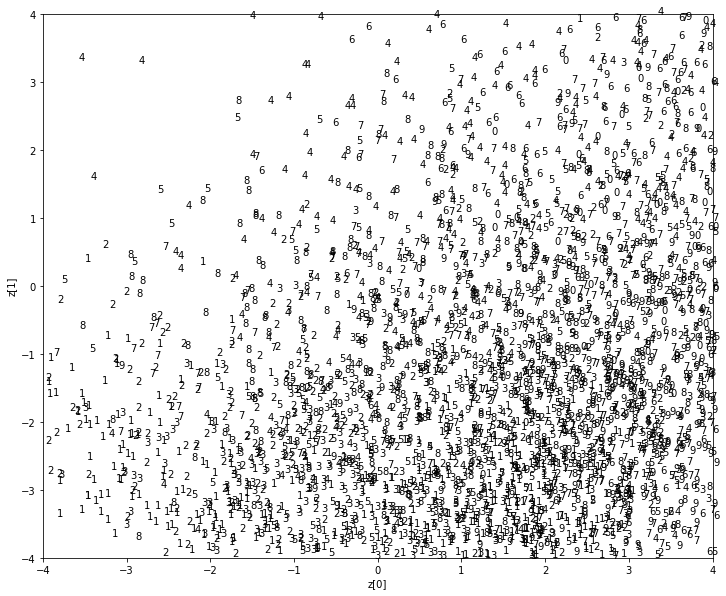

ValueError: in user code:

    File "E:\Anaconda\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "E:\Anaconda\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "E:\Anaconda\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "E:\Anaconda\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "E:\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "E:\Anaconda\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "dekoder" is incompatible with the layer: expected shape=(None, 16), found shape=(None, 2)


In [30]:
plot_results(models, data,
             batch_size=batch_size,
             model_name="autoencoder-2dim")